In [1]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression # must come before nest

from generate_triple_data import par, simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
import statsmodels.api as sm
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import pandas as pd
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

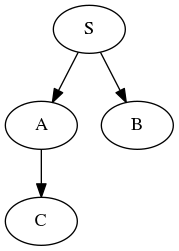

In [5]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S'])
G.add_edges_from([('A','C'), ('S', 'A'), ('S', 'B')])
draw(G, show='ipynb', filename='graph.png', format='png')

In [4]:
def xcorr(t1, t2, binsize=1e-3, limit=[-1, 1], density=False):
    '''
    Cross correlation histogram (CCH) of t1 vs t2
    '''
    if isinstance(limit, (int, float)):
        limit = [-limit, limit]
    bins = np.arange(limit[0], limit[1] + binsize, binsize)
    ii2 = np.searchsorted(t2, t1 + limit[0])
    jj2 = np.searchsorted(t2, t1 + limit[1])
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])
    count, bins = np.histogram(big, bins=bins, density=density)
    
    return bins[1:], count


def fit_latency(pre, post, binsize=.1e-3, limit=[-10e-3, 20e-3], init=[5e-4, 5e-4], plot=False):
    '''
    Fit a gaussian PDF to density of CCH
    '''
    b, c = xcorr(pre, post, binsize=binsize, limit=limit, density=True)
    normpdf  = lambda p, x: st.norm.pdf(x, *p)
    error  = lambda p, x, y: (y - normpdf(p, x))
    res, _ = leastsq(error, init, args=(b, c))
    if plot:
        plt.bar(b, c, width=-binsize, align='edge')
        y = normpdf(res, b)
        plt.plot(b, y, 'r--', linewidth=2)
        plt.title('$\Delta t$ {:.3f} $\sigma$ {:.3f}'.format(*res))
#         plt.axvspan(delta_t - sigma, delta_t + sigma, alpha=.5, color='cyan')
    return res

In [45]:
def OLS(X, y):
    dot, inv = np.dot, np.linalg.inv
    return dot(dot(inv(dot(X.T, X)), X.T), y)


def calculate_regressors(x, y, stim_times, latency, winsize):
    stim_times = stim_times.astype(float)
    
    src_x = np.searchsorted(x, stim_times, side='right')
    
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    Z = x[src_x-1] - stim_times
    X = x[src_x] - stim_times
    
    stim_win = np.insert(
        stim_times + latency, 
        np.arange(len(stim_times)) + 1, 
        stim_times + latency + winsize)
    src_y = np.searchsorted(y, stim_win, side='left')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    return Z, X, Y


# def IV(x, y, stim_times, latency, winsize): # solve
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    
#     X = np.vstack((X, np.ones(X.shape[0]))).T
    
#     ZTZ = np.dot(Z.T, Z)
#     ZTX = np.dot(Z.T, X)
    
#     X_hat_params = np.linalg.solve(ZTZ, ZTX)
    
#     X_hat = np.dot(Z, X_hat_params)
    
#     X_hatTX_hat = np.dot(X_hat.T, X_hat)
#     X_hatTY = np.dot(X_hat.T, Y)
    
#     return np.linalg.solve(X_hatTX_hat, X_hatTY)


# def IV(x, y, stim_times, latency, winsize): # OLS switched
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    
#     X = np.vstack((X, np.ones(X.shape[0]))).T
    
#     W = OLS(X, Z) # I switched and got better results
    
#     X_hat = np.dot(X, W) # I switched and got better results
# #     print(X_hat[:10])
    
#     beta_IV, _ = OLS(X_hat, Y)
    
#     return beta_IV

# def IV(x, y, stim_times, latency, winsize): # OLS
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    
#     X = np.vstack((X, np.ones(X.shape[0]))).T
    
#     W = OLS(Z, X)

#     X_hat = np.dot(Z, W)
    
#     beta_IV, _ = OLS(X_hat, Y)
    
#     return beta_IV

# def IV(x, y, stim_times, latency, winsize): # non-linear fit
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)

#     def model(x, t):
#         return x[0] * np.exp(x[1] * t)

#     def loss(x, t, y):
#         return model(x, t) - y

#     x0 = np.ones(2)
#     X_hat_nonlinear = least_squares(loss, x0, loss='soft_l1', f_scale=0.1, args=(Z, X))

#     X_hat = model(X_hat_nonlinear.x, Z)
    
#     X_hat = np.vstack((X_hat, np.ones(X_hat.shape[0]))).T
#     beta_IV, _ = OLS(X_hat, Y)
    
#     return beta_IV


def IV(x, y, stim_times, latency, winsize): # non-linear fit
            
    Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
    X = ((X > 0.001) & (X < 0.003)).astype(int)
    Z = Z.reshape(-1, 1)

    model = LogisticRegression(C=1e5)

    model.fit(Z, X)
    X_hat = model.predict(Z)

    from scipy.special import expit

    plt.scatter(Z.ravel(), X, color='black', zorder=20)

    plt.scatter(Z.ravel(), X_hat, color='blue', zorder=20)

    X_test = np.linspace(min(Z), 0, 300)


    loss = expit(X_test * model.coef_ + model.intercept_).ravel()
    plt.plot(X_test, loss, color='red', linewidth=3)
    
    X_hat = np.vstack((X_hat, np.ones(X_hat.shape[0]))).T
    beta_IV, _ = OLS(X_hat, Y)
    
    return beta_IV


# def zscore(a):
#     return (a - a.mean()) / a.std()


# def IV(x, y, stim_times, latency, winsize): # lstsq
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
# #     Z, X = zscore(Z), zscore(X)
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
#     X = np.vstack((X, np.ones(X.shape[0]))).T
#     W = np.linalg.lstsq(Z, X, rcond=None)[0]
#     X_hat = np.dot(Z, W)
    
#     beta_IV, _ = np.linalg.lstsq(X_hat, Y, rcond=None)[0]
    
#     return beta_IV


# def IV(x, y, stim_times, latency, winsize): # sm
#     from statsmodels.sandbox.regression.gmm import IV2SLS
    
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
#     X = np.vstack((X, np.ones(X.shape[0]))).T

#     return IV2SLS(Y,X,Z).fit().params[0]

In [6]:
data = simulate(par, stop_time=500, J_AC=2.0, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)
stop_time = data['status']['time'] / 1000
A_spikes, B_spikes, C_spikes = [s['times'] / 1000 for s in data['spiketrains']]

stim_times = data['epoch']['times'] / 1000

simulating  499986.8
stimulating  7955
connecting  J_AC 2.0


/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.011851465645250341

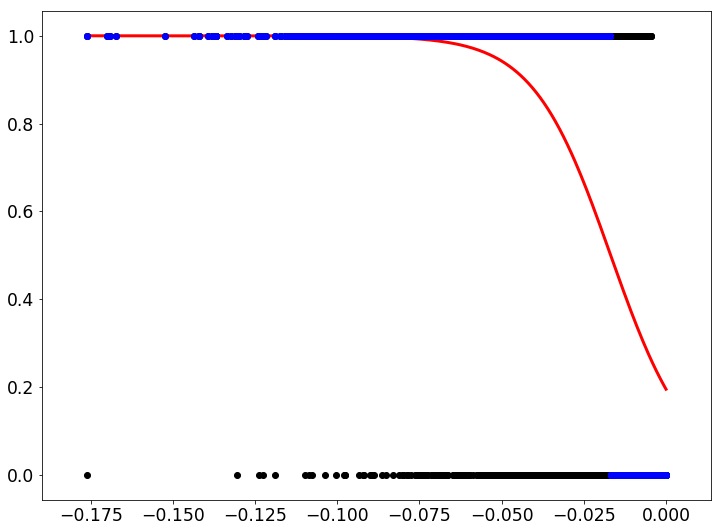

In [44]:
beta_AC = IV(B_spikes, C_spikes, stim_times, latency=0, winsize=12e-3)
beta_AC

In [50]:
Z, X, Y = calculate_regressors(A_spikes, C_spikes, stim_times, latency=0, winsize=12e-3)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5,1,'Neuron simulation')

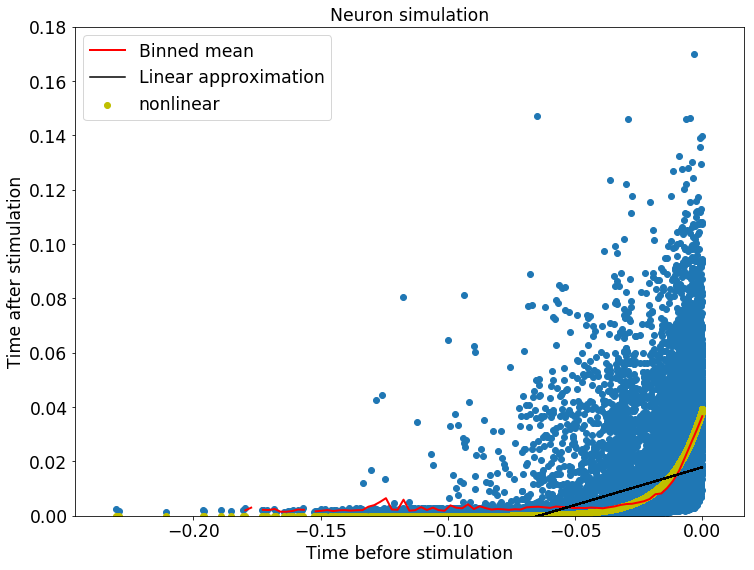

In [62]:
plt.scatter(Z, X)

a, b, c = st.binned_statistic(Z, X, statistic='mean', bins=100)

plt.plot(b[1:], a, c='r', lw=2, label='Binned mean')

plt.ylim(0, .18)

ZZ = np.vstack((Z, np.ones(Z.shape[0]))).T

XX = np.vstack((X, np.ones(X.shape[0]))).T

W = OLS(ZZ, XX)

X_hat = np.dot(ZZ, W)

plt.plot(Z, X_hat[:,0], 'k', label='Linear approximation')

plt.xlabel('Time before stimulation')

plt.ylabel('Time after stimulation')



def model(x, t):
    return x[0] * np.exp(x[1] * t)

def loss(x, t, y):
    return abs(model(x, t) - y)

x0 = np.ones(3)
X_hat_nonlinear = least_squares(loss, x0, loss='soft_l1', f_scale=0.1, args=(Z, X))

plt.scatter(Z, model(X_hat_nonlinear.x, Z), label='nonlinear', c='y')

plt.legend()

plt.title('Neuron simulation')

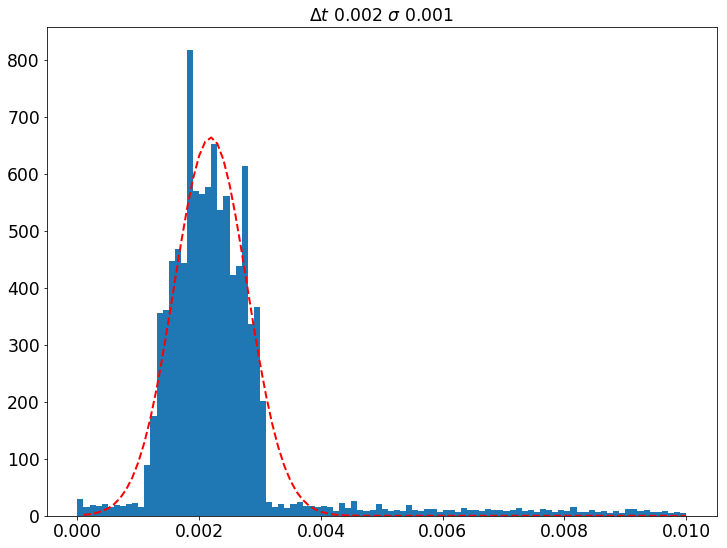

In [89]:
t, x = fit_latency(stim_times, A_spikes, limit=[0, 10e-3], plot=True)

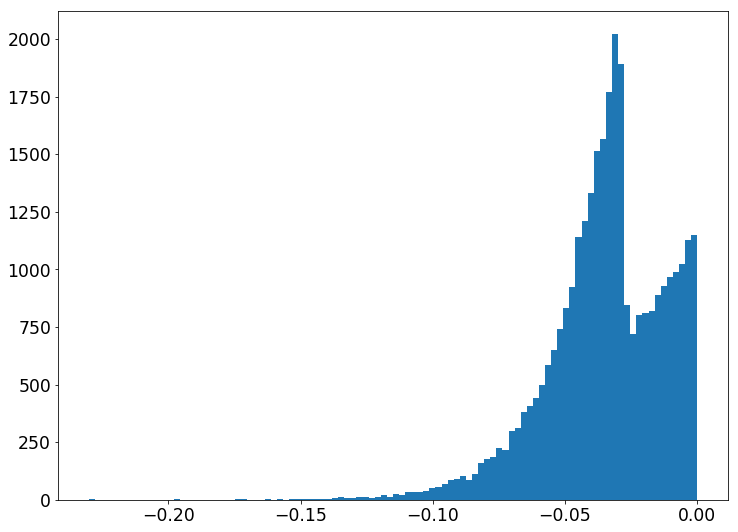

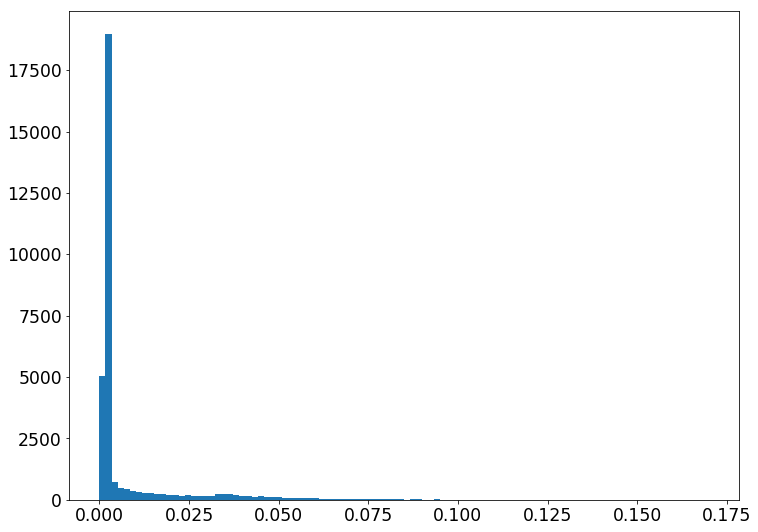

In [60]:
bins = 100#np.arange(-.1, 0, 1e-3)
plt.hist(Z, bins=bins);

plt.figure()
bins = 100#np.arange(0, 0.01, 1e-4)
plt.hist(X, bins=bins);

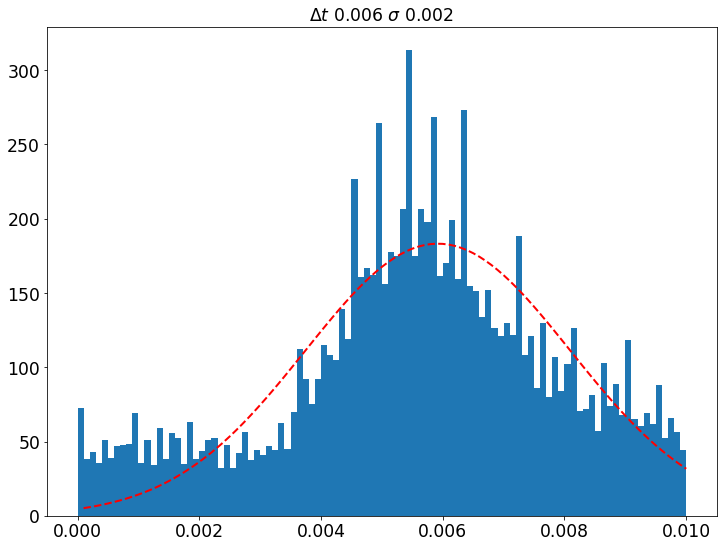

In [16]:
t, x = fit_latency(stim_times, C_spikes, limit=[0, 10e-3], plot=True)

In [17]:
beta_AC = IV(A_spikes, C_spikes, stim_times - 15, latency=0, winsize=12e-3)
beta_AC

-1.222294439260439

In [ ]:
# to_konrad = pd.DataFrame({'Z': Z, 'X': X, 'Y': Y, 'ground truth induced rate': len(C_spikes) / stop_time - results['rate_C'][0]})
# to_konrad.to_csv('iv_data.csv')

In [18]:
len(C_spikes) / stop_time, len(A_spikes) / stop_time

(21.458965665654937, 23.265962774459563)

In [ ]:
amps = np.arange(0, 3.1, .1)
simulations = defaultdict(list)
for a in amps:
    data = simulate(par, stim_N=10000, J_AC=a, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)
    stop_time = data['status']['time']
    A_spikes, B_spikes, C_spikes = [s['times'] for s in data['spiketrains']]
    
    stim_times = data['epoch']['times']
    
    simulations['stim_times'].append(stim_times)
    simulations['A_spikes'].append(A_spikes)
    simulations['B_spikes'].append(B_spikes)
    simulations['C_spikes'].append(C_spikes)
    simulations['stop_time'].append(stop_time)

In [ ]:
winsize = 8e-3
latency = 0
time_shift = 15e-3
results = defaultdict(list)
for i, a in tqdm(enumerate(amps)):

    stim_times = simulations['stim_times'][i] / 1000
    A_spikes = simulations['A_spikes'][i] / 1000
    B_spikes = simulations['B_spikes'][i] / 1000
    C_spikes = simulations['C_spikes'][i] / 1000
    stop_time = simulations['stop_time'][i] / 1000
    
    beta_AC = IV(A_spikes, C_spikes, stim_times, latency, winsize)
    beta_BC = IV(B_spikes, C_spikes, stim_times, latency, winsize)
    
    beta_ACr = IV(A_spikes, C_spikes, stim_times - time_shift, latency, winsize)
    beta_BCr = IV(B_spikes, C_spikes, stim_times - time_shift, latency, winsize)
    
    
    results['beta_AC'].append(beta_AC)
    results['beta_BC'].append(beta_BC)    
    results['beta_AC_shift'].append(beta_ACr)    
    results['beta_BC_shift'].append(beta_BCr)
    results['rate_A'].append(len(A_spikes) / stop_time)
    results['rate_B'].append(len(B_spikes) / stop_time)
    results['rate_C'].append(len(C_spikes) / stop_time)

In [ ]:
results = {k: np.array(v) for k, v in results.items()}

In [ ]:
pd.DataFrame(results).head()

In [ ]:
fig, (axa, axb) = plt.subplots(1,2, sharey=True)

s = -1

plt.suptitle('Two stage OLS method', fontsize='xx-large')

axa.plot(amps, s * results['beta_AC'], label=r'$\beta_{IV}$')
axa.plot(amps, s * results['beta_AC_shift'], label=r'$\beta_{IV}$ shifted')
axa.plot(amps, s * results['beta_AC'] - s * results['beta_AC_shift'], label=r'$\beta_{IV}$ corrected')
axa.plot(amps, results['rate_C'] - results['rate_C'][0], label='AC induced rate')
axa.legend(frameon=False, loc=0)
axa.set_xlabel('Connection strength AC')
axa.set_title('AC')

axb.plot(amps, s * results['beta_BC'], label=r'$\beta_{IV}$')
axb.plot(amps, s * results['beta_BC_shift'], label=r'$\beta_{IV}$ shifted')
axb.plot(amps, s * results['beta_BC'] - s * results['beta_BC_shift'], label=r'$\beta_{IV}$ corrected')
axb.plot(amps, np.zeros_like(amps), label='BC induced rate')
axb.legend(frameon=False, loc=0)
axb.set_xlabel('Connection strength AC')
axb.set_title('BC')

In [ ]:
fig, (axa, axb) = plt.subplots(1,2, sharey=True)

s = 1

plt.suptitle('Two stage OLS method', fontsize='xx-large')

axa.plot(amps, s * results['beta_AC'], label=r'$\beta_{IV}$')
axa.plot(amps, s * results['beta_AC_shift'], label=r'$\beta_{IV}$ shifted')
axa.plot(amps, s * results['beta_AC'] - s * results['beta_AC_shift'], label=r'$\beta_{IV}$ corrected')
axa.plot(amps, results['rate_C'] - results['rate_C'][0], label='AC induced rate')
axa.legend(frameon=False, loc=0)
axa.set_xlabel('Connection strength AC')
axa.set_title('AC')

axb.plot(amps, s * results['beta_BC'], label=r'$\beta_{IV}$')
axb.plot(amps, s * results['beta_BC_shift'], label=r'$\beta_{IV}$ shifted')
axb.plot(amps, s * results['beta_BC'] - s * results['beta_BC_shift'], label=r'$\beta_{IV}$ corrected')
axb.plot(amps, np.zeros_like(amps), label='BC induced rate')
axb.legend(frameon=False, loc=0)
axb.set_xlabel('Connection strength AC')
axb.set_title('BC')